# **Visualization - How Does BERT Answer Questions?**
In this notebook, we will carry out the following badges:

1.   Experiment with another model:
  *   Visualize hidden states of a T5 model

In [2]:
%load_ext autoreload
%autoreload 2
import json
import torch
import numpy as np
from transformers import T5ForConditionalGeneration, AutoTokenizer
from utils_T5 import *

## **1. Load pretrained model and prepare the sample**

In [4]:
# Loading finetuned T5 model and sample QA Task
tokenizer = AutoTokenizer.from_pretrained("../models/t5_finetuned_squad_v1")
model = T5ForConditionalGeneration.from_pretrained(
        "../models/t5_finetuned_squad_v1",
        cache_dir="/cache",
)

# prepare sample for input to model
sample = json.load(open("./visualization/samples/sample_paper_squad.json"))# QASample.from_json_file("./visualization/samples/sample_paper_squad.json")
sample["answers"] = {}
sample["answers"]['text'] = [sample['answer']]
sample = add_eos_to_examples(sample)
answer_start = sample["context"].lower().find(sample["answers"]['text'][0].lower())

features = tokenizer([sample['input_text']], return_tensors='pt')
features["tokens"] = tokenizer.convert_ids_to_tokens(features["input_ids"][0])
print(sample["answers"]['text'])
print(features["tokens"], features["input_ids"][0])

['detention']
['▁question', ':', '▁What', '▁is', '▁', 'a', '▁common', '▁punishment', '▁in', '▁the', '▁UK', '▁and', '▁Ireland', '?', '▁context', ':', '▁', 'Currently', '▁de', 'tention', '▁is', '▁one', '▁of', '▁the', '▁most', '▁common', '▁pun', '-', '▁', 'ish', 'ments', '▁in', '▁schools', '▁in', '▁the', '▁United', '▁States', ',', '▁the', '▁UK', ',', '▁I', 're', '-', '▁land', ',', '▁Singapore', '▁and', '▁other', '▁countries', '.', '▁It', '▁requires', '▁the', '▁pupil', '▁to', '▁remain', '▁in', '▁school', '▁at', '▁', 'a', '▁given', '▁time', '▁in', '▁the', '▁school', '▁day', '▁(', 'such', '▁as', '▁lunch', ',', '▁rece', 's', 's', '▁or', '▁after', '▁school', ');', '▁or', '▁even', '▁to', '▁attend', '▁school', '▁on', '▁', 'a', '▁non', '-', 'school', '▁day', ',', '▁', 'e', '.', 'g', '.', '▁', "'", 'S', 'atur', 'day', '▁de', 'tention', "'", '▁held', '▁at', '▁some', '▁schools', '.', '▁', 'During', '▁de', 'tention', ',', '▁students', '▁normally', '▁have', '▁to', '▁sit', '▁in', '▁', 'a', '▁classroom'

## **2. Predict answer from the model and extract answer/question/support-fact token ids/ranges**

In [5]:
# Generate answer and get hidden states
outs = model.generate(input_ids=features["input_ids"],
                        attention_mask=features["attention_mask"],
                        max_length=16,
                        early_stopping=True,
                        output_hidden_states=True,
                        return_dict_in_generate=True)

answer = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True) for ids in outs.sequences]
encoder_hstates = outs.encoder_hidden_states



In [6]:
from nltk import tokenize
# get token ids for answer/question/supporting facts
ids = features["input_ids"][0].int().numpy()
answer_index = [np.where(ids==o.numpy())[0][0] for o in outs.sequences[0] if o != 0 and o != 1] # get only the first occurence of the answer.
# question index range
question_end_index = [i for i, e in enumerate(features["tokens"]) if 'context' in e][0]
question_index_range = [0, question_end_index]
# support fact index range for squad sample
sentences =  tokenize.sent_tokenize(sample['context'])
support_sentence = [s for s in sentences if answer[0] in s][0]
sup_sent_ids = tokenizer(support_sentence, return_tensors='pt')['input_ids'][0].numpy()[:-1] # remove end token
sup_start = [x for x in range(len(ids)) if np.all(ids[x:x+len(sup_sent_ids)] == sup_sent_ids)][0]
support_facts_range = [sup_start, sup_start+len(sup_sent_ids)-1]

print(answer, answer_index, question_index_range, support_facts_range)

['detention'] [18, 19] [0, 14] [16, 50]


<ipython-input-6-8d35c7631a7a>:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  sup_start = [x for x in range(len(ids)) if np.all(ids[x:x+len(sup_sent_ids)] == sup_sent_ids)][0]


## **3. Visualize hidden states with PCA**

2021-07-13 20:58:58,632 No output path specified.


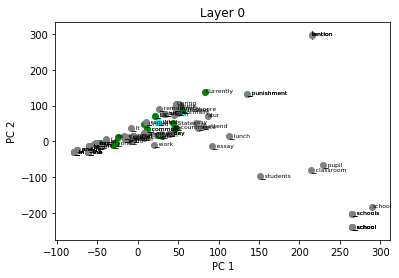

2021-07-13 20:58:59,475 No output path specified.


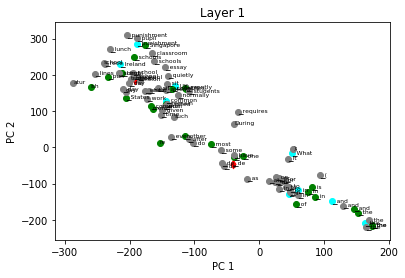

2021-07-13 20:59:00,260 No output path specified.


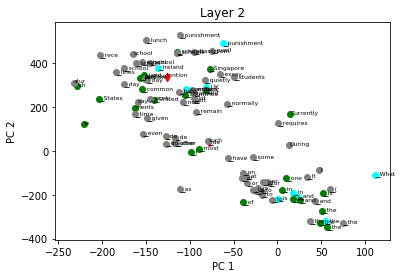

2021-07-13 20:59:01,342 No output path specified.


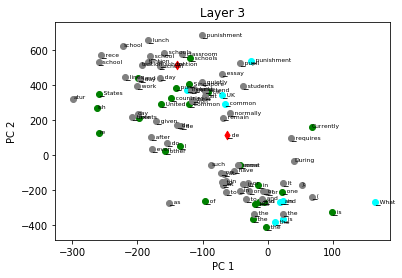

2021-07-13 20:59:02,126 No output path specified.


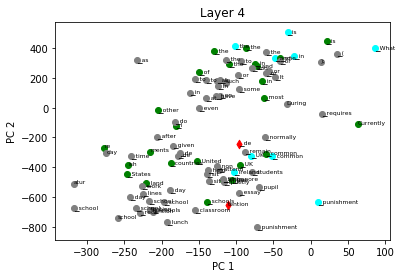

2021-07-13 20:59:03,087 No output path specified.


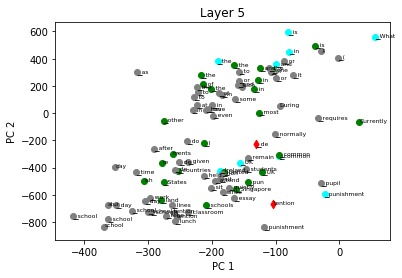

2021-07-13 20:59:03,914 No output path specified.


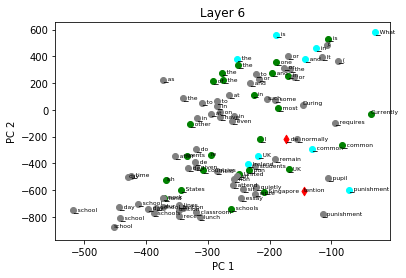

2021-07-13 20:59:04,702 No output path specified.


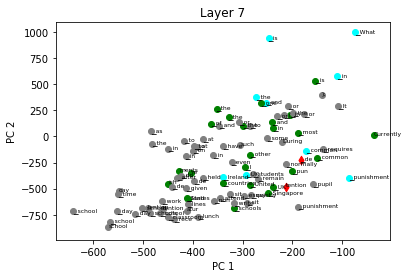

2021-07-13 20:59:05,570 No output path specified.


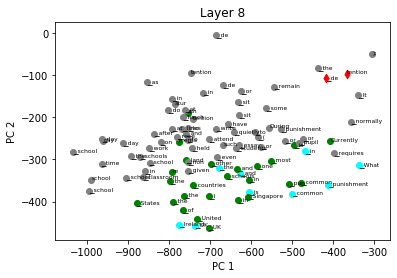

2021-07-13 20:59:06,368 No output path specified.


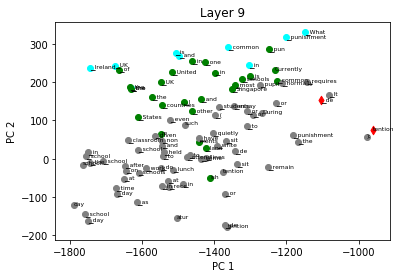

2021-07-13 20:59:07,359 No output path specified.


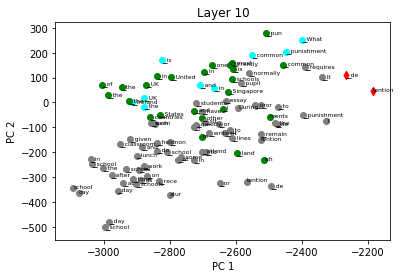

2021-07-13 20:59:08,169 No output path specified.


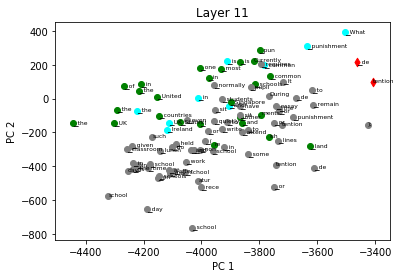

2021-07-13 20:59:08,956 No output path specified.


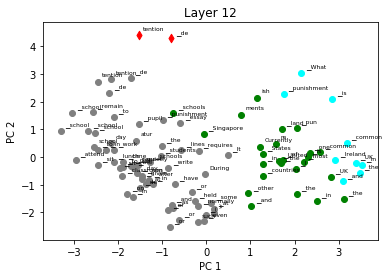

<Figure size 432x288 with 0 Axes>

In [9]:
from sklearn.decomposition import PCA
from visualization.plotting import Token2DVector, TokenPlotter, TokenLabel
from typing import List

tokens = features["tokens"]
sup_facts_pos = support_facts_range
for index, layer in enumerate(encoder_hstates):
    token_vectors: List = layer[0][:len(tokens)]
    reduction = PCA(n_components=2)
    layer_reduced = reduction.fit_transform(token_vectors.detach().numpy()).transpose()

    token_vectors = []
    for token_index, value in enumerate(layer_reduced[0]):
        label = TokenLabel.DEFAULT
        is_supporting_fact_token = False
        if sup_facts_pos[0] <= token_index <= sup_facts_pos[1]:
            label = TokenLabel.SUP_FACT
        if token_index >= answer_index[0] and token_index <= answer_index[1]:
            label = TokenLabel.PREDICTION
        elif token_index >= question_index_range[0] and token_index <= question_index_range[1]:
            label = TokenLabel.QUESTION

        token_vector = Token2DVector(x=value,
                                    y=layer_reduced[1][token_index],
                                    token=tokens[token_index],
                                    label=label)
        token_vectors.append(token_vector)
    plot_title = "Layer {}".format(index)
    token_plotter = TokenPlotter(vectors=token_vectors,
                                    title=plot_title,
                                    output_path=None)
    token_plotter.plot()